In [35]:
import config
import torch
import numpy as np
from autoencoder import ConvDecoder, ConvEncoder
from sklearn.neighbors import NearestNeighbors
import torchvision.transforms as T
import os
from PIL import Image
import matplotlib.pyplot as plt
import json
%matplotlib inline

In [36]:
def load_image_tensor(image_path, device):
    image_tensor = T.ToTensor()(Image.open(image_path))
    image_tensor = image_tensor.unsqueeze(0)
    print(image_tensor.shape)
    # input_images = image_tensor.to(device)
    return image_tensor

In [37]:
image_paths=[]
with open("geological_map.json", 'r', encoding='utf-8') as f:
    image_paths=json.load(f)
print(len(image_paths))

29998


In [42]:
def compute_similar_images(image_path, num_images, embedding, device):
    image_tensor = load_image_tensor(image_path, device)
    # image_tensor = image_tensor.to(device)

    with torch.no_grad():
        image_embedding = encoder(image_tensor).cpu().detach().numpy()

    print(image_embedding.shape)

    flattened_embedding = image_embedding.reshape((image_embedding.shape[0], -1))
    print(flattened_embedding.shape)

    knn = NearestNeighbors(n_neighbors=num_images, metric="cosine")
    knn.fit(embedding)

    _, indices = knn.kneighbors(flattened_embedding)
    indices_list = indices.tolist()
    #print(indices_list)
    return indices_list


In [49]:
def plot_similar_images(indices_list):
    indices = indices_list[0]
    print("total indices: ", len(indices))
    print(indices_list)
    for index in indices:
        # img_name = str(index - 1) + ".jpg"
        # print(img_name)
        img_path = image_paths[index]
        print(img_path)
        img = Image.open(img_path).convert("RGB")
        plt.imshow(img)
        plt.show()

In [63]:
TEST_IMAGE_PATH = "geological_similarity\schist\ZZ5Z5.jpg"
NUM_IMAGES = 10
ENCODER_MODEL_PATH = "geological_encoding.pt"
EMBEDDING_PATH = "geological_embed.npy"

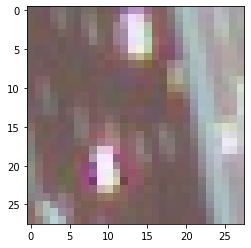

torch.Size([1, 3, 28, 28])
(1, 64, 3, 3)
(1, 576)
total indices:  10
[[27226, 26895, 29996, 6079, 28089, 27624, 27607, 6935, 29373, 27510]]
geological_similarity\schist\G4RAQ.jpg


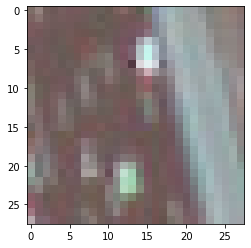

geological_similarity\schist\DQ5IN.jpg


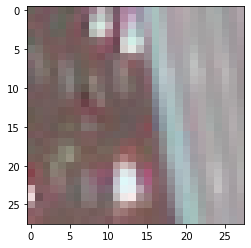

geological_similarity\schist\ZZ5Z5.jpg


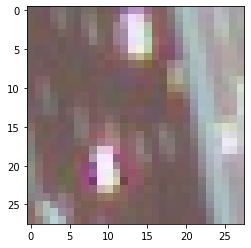

geological_similarity\gneiss\7PVRW.jpg


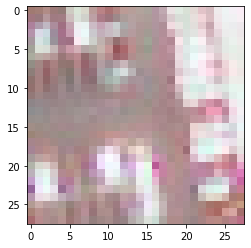

geological_similarity\schist\M9YY3.jpg


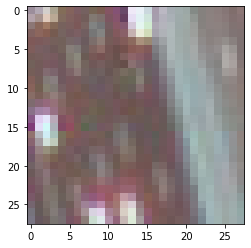

geological_similarity\schist\J11Q2.jpg


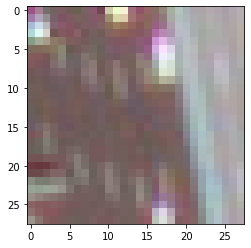

geological_similarity\schist\IY3A7.jpg


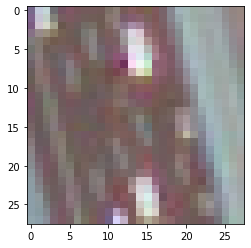

geological_similarity\gneiss\E12AS.jpg


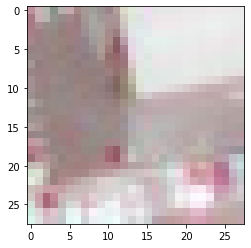

geological_similarity\schist\VOKBC.jpg


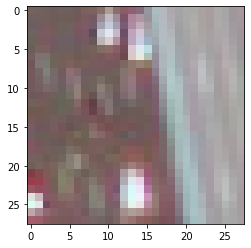

geological_similarity\schist\I5O5W.jpg


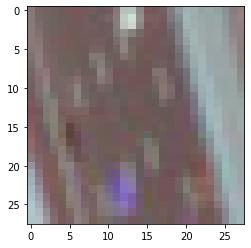

In [64]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
encoder = ConvEncoder()

# Load the state dict of encoder
encoder.load_state_dict(torch.load(ENCODER_MODEL_PATH, map_location=device))
encoder.eval()
encoder.to(device)

# Loads the embedding
embedding = np.load(EMBEDDING_PATH)
test_img = Image.open(TEST_IMAGE_PATH).convert("RGB")
plt.imshow(test_img)
plt.show()
indices_list = compute_similar_images(TEST_IMAGE_PATH, NUM_IMAGES, embedding, device)
plot_similar_images(indices_list)

In [62]:
len(embedding)

29998